In [38]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import pandas as pd
from oggm import utils
import numpy as np

In [93]:
df_rgi = pd.read_hdf(utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5'))
df_rgi = df_rgi.groupby('O1Region').sum()

In [94]:
df_vol = pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5'))
df_vol['REG'] = [s[6:8] for s in df_vol.index]

df_vol = df_vol.groupby('REG').sum()

In [95]:
sel_exp = 'cru_match_160'

In [96]:
if 'cru' in sel_exp and len(df_vol) == 19:
    df_vol = df_vol.iloc[:-1]

In [97]:
df = pd.DataFrame()
df_bsl = pd.DataFrame()
for reg in range(1, 20):
    
    if 'cru' in sel_exp and reg > 18:
        continue
    
    reg = f'{reg:02d}'
    fp = f'output_{sel_exp}/RGI{reg}.nc'
    with xr.open_dataset(fp) as ds:
        ok_area = float(ds['area'].isel(time=0).sum()) * 1e-6
        perc_missing = (1 - ok_area / df_rgi['Area'][reg]) * 100
        print(f'RGI{reg} Missing glacier area: {perc_missing:.2f}')
        df[f'RGI{reg}'] = ds.volume.sum(dim='rgi_id').to_series()
        df_bsl[f'RGI{reg}'] = ds.volume_bsl.sum(dim='rgi_id').to_series()

RGI01 Missing glacier area: 4.07
RGI02 Missing glacier area: 1.56
RGI03 Missing glacier area: 25.56
RGI04 Missing glacier area: 0.00
RGI05 Missing glacier area: 63.77
RGI06 Missing glacier area: 49.17
RGI07 Missing glacier area: 94.88
RGI08 Missing glacier area: 0.58
RGI09 Missing glacier area: 75.93
RGI10 Missing glacier area: 3.60
RGI11 Missing glacier area: 0.83
RGI12 Missing glacier area: 12.05
RGI13 Missing glacier area: 4.11
RGI14 Missing glacier area: 1.61
RGI15 Missing glacier area: 1.08
RGI16 Missing glacier area: 7.73
RGI17 Missing glacier area: 4.93
RGI18 Missing glacier area: 0.25


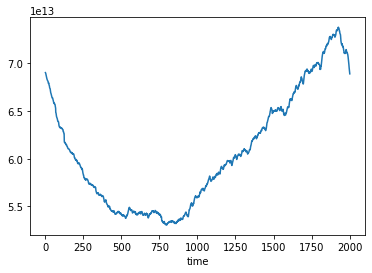

In [98]:
df.sum(axis=1).plot();

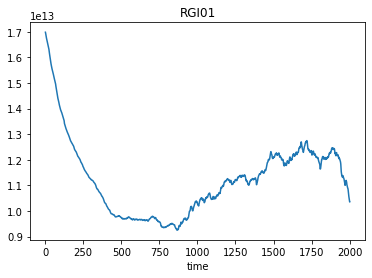

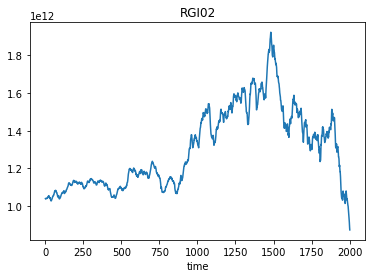

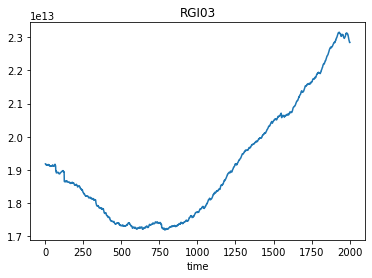

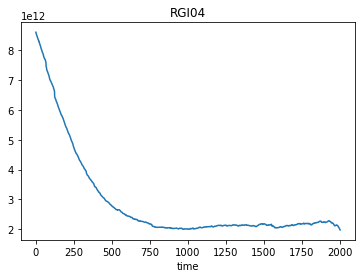

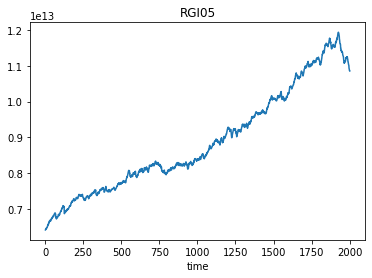

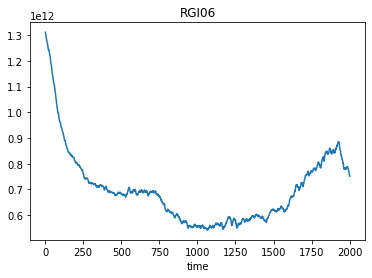

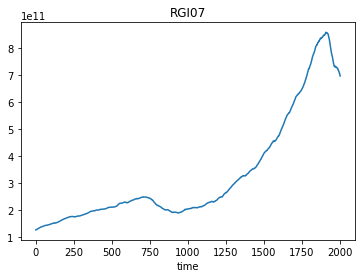

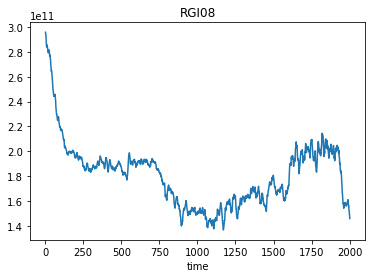

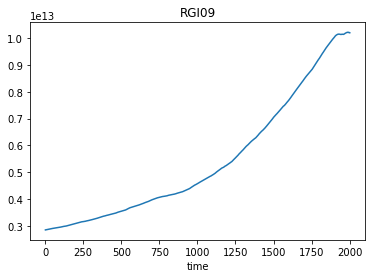

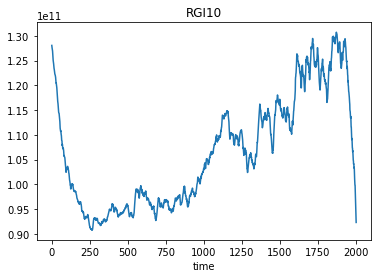

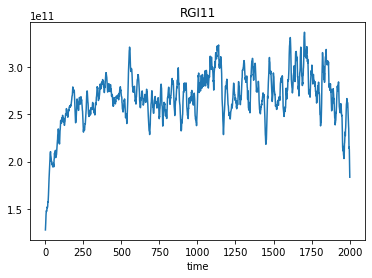

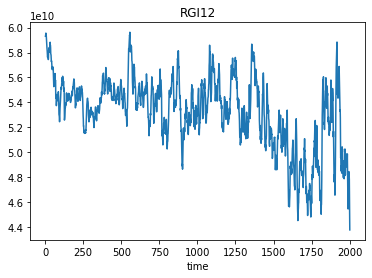

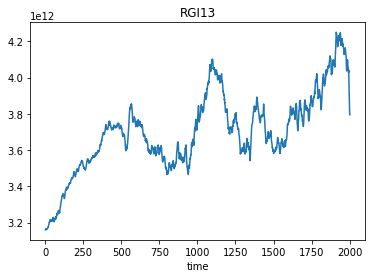

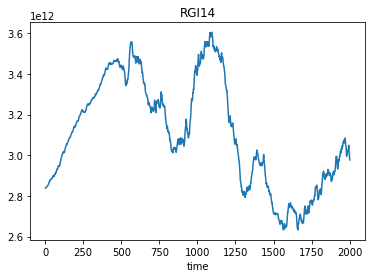

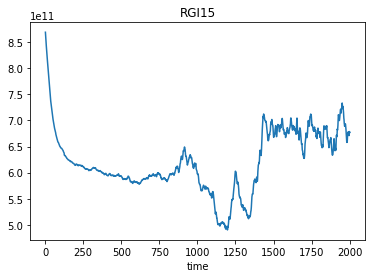

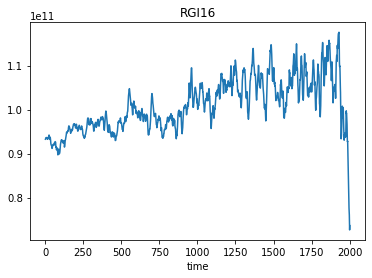

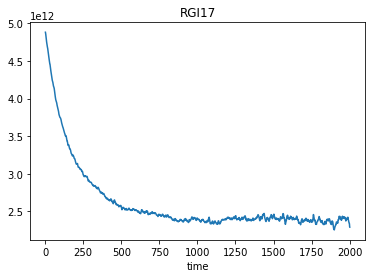

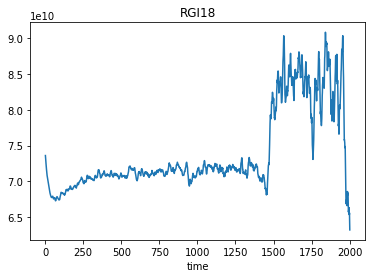

In [99]:
for c in df.columns:
    plt.figure();
    df[c].plot();
    plt.title(c);

## Testing the influence of scaling volume 

In [100]:
# For example region 11
reg = 1
reg = f'{reg:02d}'
fp = f'output_{sel_exp}/RGI{reg}.nc'
#     fp = f'output_cru_160/RGI{reg}.nc'
#     fp = f'output_cera_nobias_240/RGI{reg}.nc'
with xr.open_dataset(fp) as ds:
    ds = ds.load()
    volume_ok = ds.volume.isel(rgi_id=~ds.volume.isel(time=0).isnull().data).load()

In [101]:
tdf = pd.DataFrame(volume_ok.data, columns=volume_ok.rgi_id, index=volume_ok.time).T

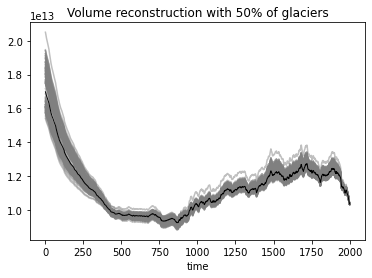

In [102]:
target = tdf[2001].sum()
for i in range(100):
    data = tdf.sample(frac=0.5)
    fac = target / data[2001].sum()
    data = data.sum() * fac
    data.plot(color='grey', alpha=0.5);
tdf.sum().plot(linewidth=1, color='k');
plt.title('Volume reconstruction with 50% of glaciers');

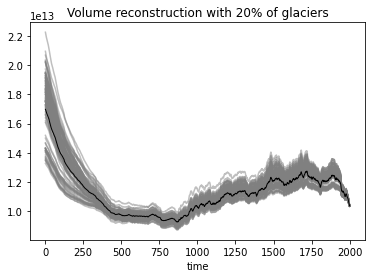

In [103]:
target = tdf[2001].sum()
for i in range(100):
    data = tdf.sample(frac=0.2)
    fac = target / data[2001].sum()
    data = data.sum() * fac
    data.plot(color='grey', alpha=0.5);
tdf.sum().plot(linewidth=1, color='k');
plt.title('Volume reconstruction with 20% of glaciers');

## Correct the volume per region now 

In [104]:
fac_per_reg = df_vol.vol_itmix_m3.values / df.iloc[-1] 
fac_per_reg

RGI01     1.832184
RGI02     1.198051
RGI03     1.240371
RGI04     4.363087
RGI05     1.445248
RGI06     5.014775
RGI07    10.734782
RGI08     2.047364
RGI09     1.433891
RGI10     1.471046
RGI11     0.697479
RGI12     1.441370
RGI13     0.861877
RGI14     0.962343
RGI15     1.295260
RGI16     1.336069
RGI17     2.331853
RGI18     1.165754
Name: 2001.0, dtype: float64

In [105]:
df_cor = df * fac_per_reg

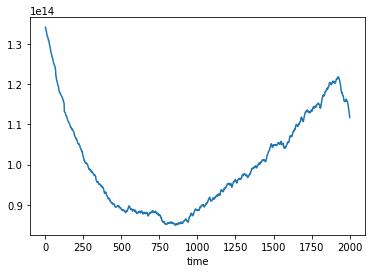

In [106]:
df_cor.sum(axis=1).plot();

Assume the fraction of vol bsl to be constant:

In [107]:
frac_bsl = df_vol.vol_bsl_itmix_m3 / df_vol.vol_itmix_m3
frac_bsl.index = fac_per_reg.index

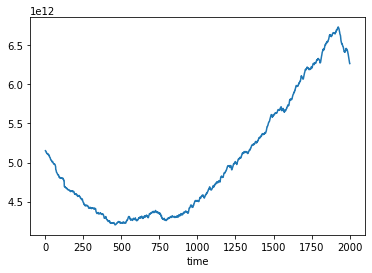

In [108]:
df_cor_bsl = df_cor * frac_bsl
df_cor_bsl.sum(axis=1).plot();

In [109]:
# SLR
rho = 900
rho_w = 1000
A_oc = 362.5 * 1e9
slr = (df_cor.sum(axis=1) * (rho / rho_w) - df_cor_bsl.sum(axis=1)) / A_oc
slr = slr.loc[1850] - slr

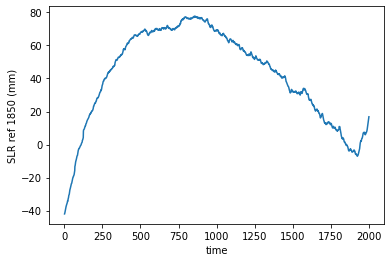

In [110]:
slr.plot();
plt.ylabel('SLR ref 1850 (mm)');

In [111]:
fdf[sel_exp] = slr

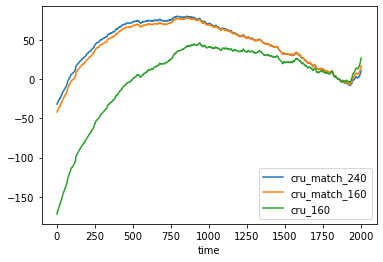

In [113]:
fdf[['cru_match_240', 'cru_match_160', 'cru_160']].plot();